In [1]:
import os
import glob
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression


## set up pyspark session

In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/17 15:15:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## set up config

In [3]:
# set up config
model_train_date_str = "2024-08-01"
train_test_period_months = 3
oot_period_months = 1
train_test_ratio = 0.8

config = {}
config["model_train_date_str"] = model_train_date_str
config["train_test_period_months"] = train_test_period_months
config["oot_period_months"] =  oot_period_months
config["model_train_date"] =  datetime.strptime(model_train_date_str, "%Y-%m-%d")
config["oot_end_date"] =  config['model_train_date'] - timedelta(days = 1)
config["oot_start_date"] =  config['model_train_date'] - relativedelta(months = oot_period_months)
config["train_test_end_date"] =  config["oot_start_date"] - timedelta(days = 1)
config["train_test_start_date"] =  config["oot_start_date"] - relativedelta(months = train_test_period_months)
config["train_test_ratio"] = train_test_ratio 


pprint.pprint(config)

{'model_train_date': datetime.datetime(2024, 8, 1, 0, 0),
 'model_train_date_str': '2024-08-01',
 'oot_end_date': datetime.datetime(2024, 7, 31, 0, 0),
 'oot_period_months': 1,
 'oot_start_date': datetime.datetime(2024, 7, 1, 0, 0),
 'train_test_end_date': datetime.datetime(2024, 6, 30, 0, 0),
 'train_test_period_months': 3,
 'train_test_ratio': 0.8,
 'train_test_start_date': datetime.datetime(2024, 4, 1, 0, 0)}


## get label store

In [4]:
# connect to label store
folder_path = "datamart/gold/label_store/"
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
label_store_sdf = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",label_store_sdf.count())

label_store_sdf.show()

row_count: 26068
+----------+-----+-------------+
|customerID|Churn|Snapshot_Date|
+----------+-----+-------------+
|7590-VHVEG|    0|   2024-06-01|
|5575-GNVDE|    0|   2024-06-01|
|3668-QPYBK|    1|   2024-06-01|
|7795-CFOCW|    0|   2024-06-01|
|9237-HQITU|    1|   2024-06-01|
|9305-CDSKC|    1|   2024-06-01|
|1452-KIOVK|    0|   2024-06-01|
|6713-OKOMC|    0|   2024-06-01|
|7892-POOKP|    1|   2024-06-01|
|6388-TABGU|    0|   2024-06-01|
|9763-GRSKD|    0|   2024-06-01|
|7469-LKBCI|    0|   2024-06-01|
|8091-TTVAX|    0|   2024-06-01|
|0280-XJGEX|    1|   2024-06-01|
|5129-JLPIS|    0|   2024-06-01|
|3655-SNQYZ|    0|   2024-06-01|
|8191-XWSZG|    0|   2024-06-01|
|9959-WOFKT|    0|   2024-06-01|
|4190-MFLUW|    1|   2024-06-01|
|4183-MYFRB|    0|   2024-06-01|
+----------+-----+-------------+
only showing top 20 rows



In [5]:
label_store_sdf.select("Snapshot_Date").distinct().orderBy("Snapshot_Date").show(10, False)

+-------------+
|Snapshot_Date|
+-------------+
|2024-04-01   |
|2024-05-01   |
|2024-06-01   |
|2024-07-01   |
+-------------+



In [6]:
# extract label store
labels_sdf = label_store_sdf.filter((col("Snapshot_Date") >= config["train_test_start_date"]) & (col("Snapshot_Date") <= config["oot_end_date"]))

print("extracted labels_sdf", labels_sdf.count(), config["train_test_start_date"], config["oot_end_date"])

extracted labels_sdf 26068 2024-04-01 00:00:00 2024-07-31 00:00:00


## get features from feature store

In [7]:
import os
import glob

# Define the folder path to the feature store
folder_path_fe = "datamart/gold/feature_store/"

# List all .parquet files in the folder with full paths
files_list = glob.glob(os.path.join(folder_path_fe, "*.parquet"))

# Filter out empty files (size == 0 bytes)
valid_files = [f for f in files_list if os.path.getsize(f) > 0]

# Print valid file paths (optional for debugging)
print("Valid non-empty parquet files found:")
for f in valid_files:
    print(f)

# Ensure there are valid files before trying to read
if valid_files:
    # Read the parquet files using Spark
    features_store_sdf = spark.read.option("header", "true").parquet(*valid_files)
    
    # Print row count and preview data
    print("row_count:", features_store_sdf.count())
    features_store_sdf.show()
else:
    print("No valid non-empty parquet files found in the directory.")


Valid non-empty parquet files found:
datamart/gold/feature_store/gold_feature_store_2024-04-01.parquet
datamart/gold/feature_store/gold_feature_store_2024-05-01.parquet
datamart/gold/feature_store/gold_feature_store_2024-06-01.parquet
datamart/gold/feature_store/gold_feature_store_2024-07-01.parquet
row_count: 25124
+----------+-------------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+------+-------------+-------+----------+
|customerID|Snapshot_Date|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|gender|SeniorCitizen|Partner|Dependents|
+----------+-------------+------+------------+-------------+---------------+--------------+------------+------------

In [8]:
# extract label store
features_sdf = features_store_sdf.filter((col("snapshot_date") >= config["train_test_start_date"]) & (col("snapshot_date") <= config["oot_end_date"]))

print("extracted features_sdf", features_sdf.count(), config["train_test_start_date"], config["oot_end_date"])

extracted features_sdf 25124 2024-04-01 00:00:00 2024-07-31 00:00:00


## prepare data for modeling

In [9]:
# prepare data for modeling
data_pdf = labels_sdf.join(features_sdf, on=["customerID", "snapshot_date"], how="left").toPandas()
data_pdf

,customerID,Snapshot_Date,Churn,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2024-06-01,0,1.0,0.0,No,DSL,No,Yes,No,...,No,Month-to-month,1.0,Electronic check,29.85,29.85,0.0,0.0,1.0,0.0
1,5575-GNVDE,2024-06-01,0,34.0,1.0,No,DSL,Yes,No,Yes,...,No,One year,0.0,Mailed check,56.95,1889.50,1.0,0.0,0.0,0.0
2,3668-QPYBK,2024-06-01,1,2.0,1.0,No,DSL,Yes,Yes,No,...,No,Month-to-month,1.0,Mailed check,53.85,108.15,1.0,0.0,0.0,0.0
3,7795-CFOCW,2024-06-01,0,45.0,0.0,No,DSL,Yes,No,Yes,...,No,One year,0.0,Bank transfer (automatic),42.30,1840.75,1.0,0.0,0.0,0.0
4,9237-HQITU,2024-06-01,1,2.0,1.0,No,Fiber optic,No,No,No,...,No,Month-to-month,1.0,Electronic check,70.70,151.65,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26063,3458-GDKLN,2024-07-01,0,1.0,1.0,No,Fiber optic,No,No,No,...,No,Month-to-month,1.0,Electronic check,97.95,97.95,0.0,0.0,0.0,0.0
26064,4010-WBPGY,2024-07-01,0,7.0,1.0,No,Fiber optic,No,No,No,...,No,Month-to-month,1.0,Electronic check,85.49,611.70,1.0,0.0,0.0,0.0
26065,5374-KFGMC,2024-07-01,1,12.0,1.0,Yes,Fiber optic,No,No,Yes,...,No,Month-to-month,1.0,Electronic check,72.50,878.52,1.0,1.0,0.0,0.0
26066,1517-UTLAA,2024-07-01,1,1.0,1.0,No,Fiber optic,No,Yes,No,...,No,Month-to-month,1.0,Electronic check,76.06,80.66,0.0,0.0,1.0,0.0


In [10]:
# split data into train - test - oot
oot_pdf = data_pdf[(data_pdf['Snapshot_Date'] >= config["oot_start_date"].date()) & (data_pdf['Snapshot_Date'] <= config["oot_end_date"].date())]
train_test_pdf = data_pdf[(data_pdf['Snapshot_Date'] >= config["train_test_start_date"].date()) & (data_pdf['Snapshot_Date'] <= config["train_test_end_date"].date())]

feature_cols = [col for col in oot_pdf.columns if col not in ["customerID", "Snapshot_Date"]]

X_oot = oot_pdf[feature_cols]
y_oot = oot_pdf["Churn"]
X_train, X_test, y_train, y_test = train_test_split(
    train_test_pdf[feature_cols], train_test_pdf["Churn"], 
    test_size= 1 - config["train_test_ratio"],
    random_state=88,     # Ensures reproducibility
    shuffle=True,        # Shuffle the data before splitting
    stratify=train_test_pdf["Churn"]           # Stratify based on the label column
)


print('X_train', X_train.shape[0])
print('X_test', X_test.shape[0])
print('X_oot', X_oot.shape[0])
print('y_train', y_train.shape[0], round(y_train.mean(),2))
print('y_test', y_test.shape[0], round(y_test.mean(),2))
print('y_oot', y_oot.shape[0], round(y_oot.mean(),2))

X_train

X_train 16395
X_test 4099
X_oot 5574
y_train 16395 0.16
y_test 4099 0.16
y_oot 5574 0.09


,Churn,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents
2441,0,2.0,1.0,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,0.0,Mailed check,81.50,162.55,0.0,1.0,0.0,0.0
16712,0,56.0,0.0,No,DSL,Yes,Yes,Yes,No,Yes,No,One year,0.0,Mailed check,50.00,2819.85,1.0,0.0,1.0,1.0
19655,1,11.0,1.0,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,1.0,Credit card (automatic),102.25,1154.50,1.0,0.0,1.0,0.0
11377,0,1.0,1.0,No,DSL,No,No,No,No,No,No,Month-to-month,1.0,Electronic check,44.15,48.50,1.0,1.0,0.0,0.0
16054,0,17.0,1.0,No,No,No,No,No,No,No,No,One year,0.0,Credit card (automatic),20.25,343.15,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5947,1,33.0,1.0,Yes,No,No,No,No,No,No,No,Two year,1.0,Mailed check,24.50,740.30,0.0,0.0,1.0,1.0
19255,0,2.0,1.0,No,No,No,No,No,No,No,No,One year,0.0,Mailed check,19.95,28.30,1.0,0.0,0.0,0.0
17302,0,69.0,1.0,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,No,Two year,0.0,Credit card (automatic),100.20,7008.60,1.0,0.0,1.0,1.0
11262,0,2.0,1.0,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,1.0,Electronic check,75.85,180.75,0.0,0.0,1.0,0.0


## Preprocess data

Data Cleaning

In [11]:
# Set up StandardScaler preprocessing

# Check for missing values
print("Missing values in X_train:\n", X_train.isnull().sum())

# Identify column types
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Handle missing values for numerical columns (use median)
for col in numerical_cols:
    median_val = X_train[col].median()
    X_train.loc[:, col] = X_train[col].fillna(median_val)
    X_test.loc[:, col] = X_test[col].fillna(median_val)
    X_oot.loc[:, col] = X_oot[col].fillna(median_val)

# Handle missing values for categorical columns (use mode)
for col in categorical_cols:
    if not X_train[col].mode().empty:
        mode_val = X_train[col].mode()[0]
    else:
        mode_val = 'Unknown'
        
    X_train.loc[:, col] = X_train[col].fillna(mode_val)
    X_test.loc[:, col] = X_test[col].fillna(mode_val)
    X_oot.loc[:, col] = X_oot[col].fillna(mode_val)



Missing values in X_train:
 Churn                 0
tenure              705
PhoneService        705
MultipleLines       705
InternetService     705
OnlineSecurity      705
OnlineBackup        705
DeviceProtection    705
TechSupport         705
StreamingTV         705
StreamingMovies     705
Contract            705
PaperlessBilling    712
PaymentMethod       705
MonthlyCharges      705
TotalCharges        705
gender              705
SeniorCitizen       705
Partner             705
Dependents          705
dtype: int64


Feature Engineering

In [12]:
def create_tenure_groups(df):
    df = df.copy()  # ensure we're not editing a view
    df['tenure_group'] = pd.cut(df['tenure'], 
                                bins=[0, 12, 24, 36, 48, 60, 72, np.inf],
                                labels=['0-1yr', '1-2yr', '2-3yr', '3-4yr', '4-5yr', '5-6yr', '6+yr'])
    return df

X_train = create_tenure_groups(X_train)
X_test = create_tenure_groups(X_test)
X_oot = create_tenure_groups(X_oot)


In [13]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Identify categorical and numerical features
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns

# Remove target variable if it's in numerical features
numerical_features = numerical_features.drop('Churn', errors='ignore')

# Create transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit and transform the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
X_oot_preprocessed = preprocessor.transform(X_oot)

## Train model

### Logistic Regression

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

log_reg = LogisticRegression(
    solver='liblinear', 
    random_state=42,
    max_iter=1000
)

log_reg.fit(X_train_preprocessed, y_train)

# Make predictions
y_pred = log_reg.predict(X_test_preprocessed)
y_pred_proba = log_reg.predict_proba(X_test_preprocessed)[:, 1]

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      3427
           1       0.58      0.19      0.29       672

    accuracy                           0.84      4099
   macro avg       0.72      0.58      0.60      4099
weighted avg       0.81      0.84      0.81      4099


Confusion Matrix:
[[3331   96]
 [ 541  131]]

ROC AUC Score: 0.8170978104547917


In [15]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # Use 'liblinear' for L1 support
}

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train_preprocessed, y_train)

# Get best model
best_log_reg = grid_search.best_estimator_

# Evaluate best model
y_pred_best = best_log_reg.predict(X_test_preprocessed)
y_pred_proba_best = best_log_reg.predict_proba(X_test_preprocessed)[:, 1]

print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred_best))
print("\nROC AUC Score (Best Model):", roc_auc_score(y_test, y_pred_proba_best))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      3427
           1       0.57      0.19      0.28       672

    accuracy                           0.84      4099
   macro avg       0.71      0.58      0.60      4099
weighted avg       0.81      0.84      0.81      4099


ROC AUC Score (Best Model): 0.8173427143690858


In [16]:
# Evaluate on out-of-time data
oot_pred = best_log_reg.predict(X_oot_preprocessed)
oot_pred_proba = best_log_reg.predict_proba(X_oot_preprocessed)[:, 1]

print("OOT Classification Report:")
print(classification_report(y_oot, oot_pred))
print("\nOOT ROC AUC Score:", roc_auc_score(y_oot, oot_pred_proba))

OOT Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5085
           1       0.74      0.43      0.54       489

    accuracy                           0.94      5574
   macro avg       0.84      0.71      0.75      5574
weighted avg       0.93      0.94      0.93      5574


OOT ROC AUC Score: 0.8082903523535481


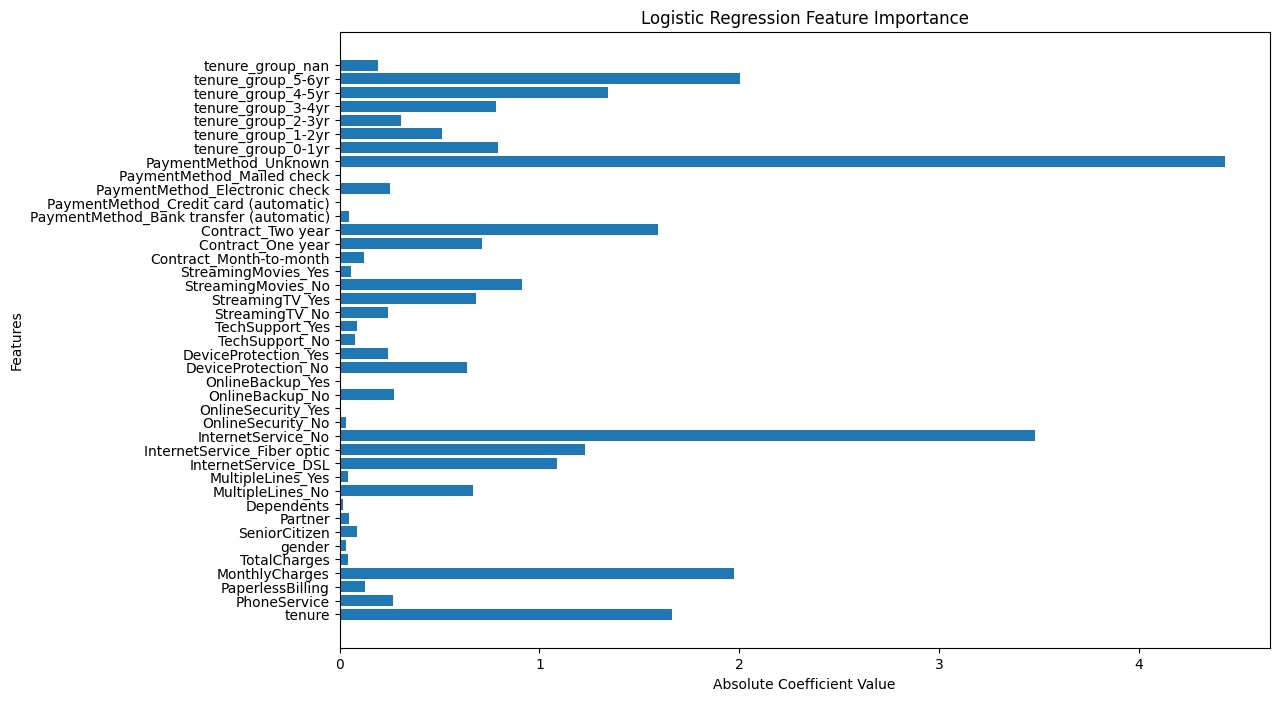

In [17]:
import matplotlib.pyplot as plt

# Get feature names after one-hot encoding
feature_names = (list(numerical_features) + 
                list(preprocessor.named_transformers_['cat']
                    .get_feature_names_out(categorical_features)))

# Plot feature importance
coefficients = best_log_reg.coef_[0]
plt.figure(figsize=(12, 8))
plt.barh(feature_names, np.abs(coefficients))
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Features')
plt.title('Logistic Regression Feature Importance')
plt.show()

### XGBoost

In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize and train the model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
)

xgb_model.fit(X_train_preprocessed, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test_preprocessed)
y_pred_proba = xgb_model.predict_proba(X_test_preprocessed)[:, 1]

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      3427
           1       0.48      0.24      0.32       672

    accuracy                           0.83      4099
   macro avg       0.67      0.60      0.61      4099
weighted avg       0.80      0.83      0.81      4099


Confusion Matrix:
[[3246  181]
 [ 508  164]]

ROC AUC Score: 0.8409370788000055


In [20]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train_preprocessed, y_train)

# Get best model
best_xgb = random_search.best_estimator_

# Evaluate best model
y_pred_best = best_xgb.predict(X_test_preprocessed)
y_pred_proba_best = best_xgb.predict_proba(X_test_preprocessed)[:, 1]

print("Best Parameters:", random_search.best_params_)
print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred_best))
print("\nROC AUC Score (Best Model):", roc_auc_score(y_test, y_pred_proba_best))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.6}

Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.86      0.95      0.91      3427
           1       0.49      0.23      0.31       672

    accuracy                           0.84      4099
   macro avg       0.68      0.59      0.61      4099
weighted avg       0.80      0.84      0.81      4099


ROC AUC Score (Best Model): 0.8486517692136673


In [21]:
# Evaluate on out-of-time data
oot_pred = best_xgb.predict(X_oot_preprocessed)
oot_pred_proba = best_xgb.predict_proba(X_oot_preprocessed)[:, 1]

print("OOT Classification Report:")
print(classification_report(y_oot, oot_pred))
print("\nOOT ROC AUC Score:", roc_auc_score(y_oot, oot_pred_proba))

OOT Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5085
           1       0.75      0.32      0.45       489

    accuracy                           0.93      5574
   macro avg       0.85      0.65      0.70      5574
weighted avg       0.92      0.93      0.92      5574


OOT ROC AUC Score: 0.8272701497849442


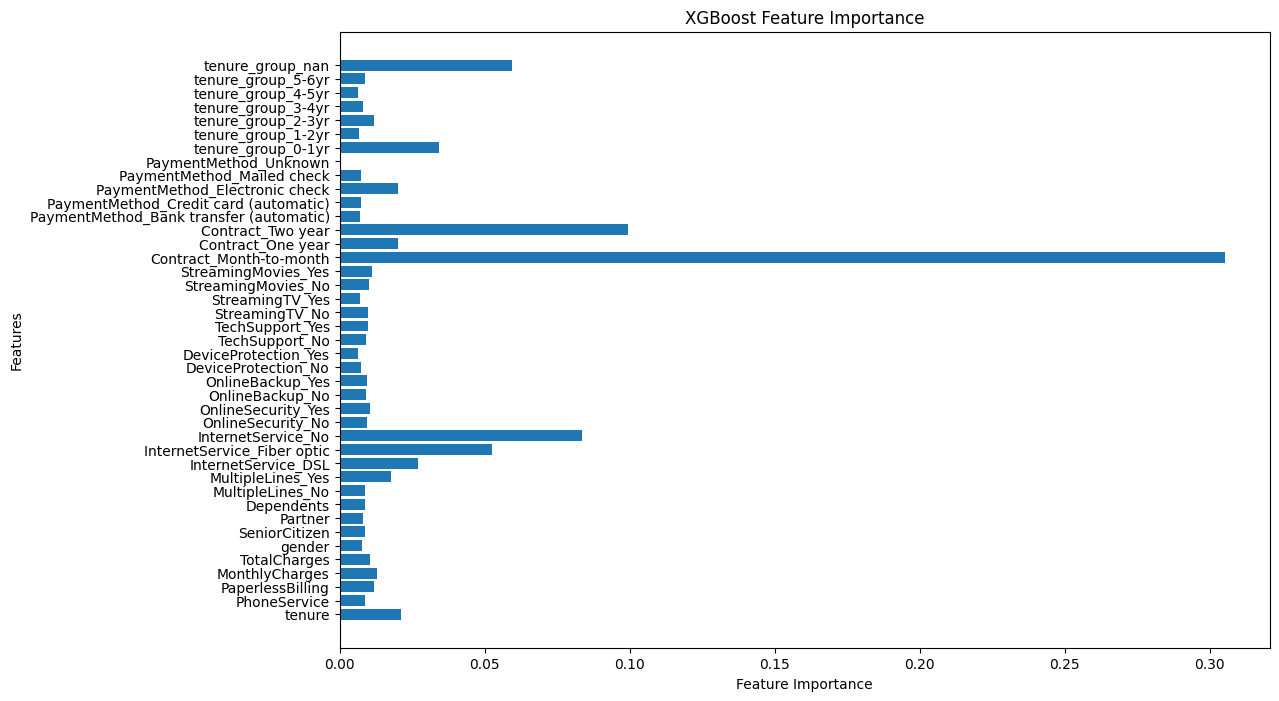

In [22]:
import matplotlib.pyplot as plt

# Get feature names after one-hot encoding
feature_names = (list(numerical_features) + 
                list(preprocessor.named_transformers_['cat']
                    .get_feature_names_out(categorical_features)))

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_names, best_xgb.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.show()

## prepare model artefact to save

Logistic Regression

In [23]:
import joblib
import os

# Create directory if it doesn't exist
os.makedirs('model_artifacts', exist_ok=True)

# Save preprocessor and model
joblib.dump(preprocessor, 'model_artifacts/preprocessor.joblib')
joblib.dump(best_log_reg, 'model_artifacts/log_reg_churn_model.joblib')

# Alternatively, save as pickle
import pickle
with open('model_artifacts/lr_model_pipeline.pkl', 'wb') as f:
    pickle.dump({'preprocessor': preprocessor, 'model': best_log_reg}, f)

XGBoost

In [24]:
import joblib
import os

# Create directory if it doesn't exist
os.makedirs('model_artifacts', exist_ok=True)

# Save preprocessor and model
joblib.dump(preprocessor, 'model_artifacts/preprocessor.joblib')
joblib.dump(best_xgb, 'model_artifacts/xgb_churn_model.joblib')

# Alternatively, save as pickle
import pickle
with open('model_artifacts/xgb_model_pipeline.pkl', 'wb') as f:
    pickle.dump({'preprocessor': preprocessor, 'model': best_xgb}, f)

## save artefact to model bank

## test load pickle and make model inference

In [25]:
# Load the saved model
with open('model_artifacts/lr_model_pipeline.pkl', 'rb') as f:
    pipeline = pickle.load(f)

loaded_preprocessor = pipeline['preprocessor']
loaded_model = pipeline['model']

# Test prediction
sample_data = X_test.iloc[0:1]  # Get first row of test data
sample_preprocessed = loaded_preprocessor.transform(sample_data)
prediction = loaded_model.predict(sample_preprocessed)
prediction_proba = loaded_model.predict_proba(sample_preprocessed)

print("Prediction:", prediction)
print("Prediction Probability:", prediction_proba)

Prediction: [0]
Prediction Probability: [[0.97764594 0.02235406]]


In [26]:
# Load the saved model
with open('model_artifacts/xgb_model_pipeline.pkl', 'rb') as f:
    pipeline = pickle.load(f)

loaded_preprocessor = pipeline['preprocessor']
loaded_model = pipeline['model']

# Test prediction
sample_data = X_test.iloc[0:1]  # Get first row of test data
sample_preprocessed = loaded_preprocessor.transform(sample_data)
prediction = loaded_model.predict(sample_preprocessed)
prediction_proba = loaded_model.predict_proba(sample_preprocessed)

print("Prediction:", prediction)
print("Prediction Probability:", prediction_proba)

Prediction: [0]
Prediction Probability: [[0.99418455 0.00581544]]
